In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from datetime import datetime
import scipy
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering

import os
os.chdir('D:\\Imperial MSc\\Electives\\Digital Marketing Analytics\\Project')

In [6]:
# Read in Search Data
searchData = pd.read_csv('data\\train.csv')

# Normalise the price to per night prices
searchData['price_usd_pernight'] = searchData['price_usd'] / searchData['srch_length_of_stay']

# Exponent the log historical price to get the actual hisotircal price
searchData['prop_historical_price'] = np.exp(searchData['prop_log_historical_price'])

# Create log price column
searchData['log_price_usd'] = np.log(searchData['price_usd'])
# Some price is 0 and will result in -Inf, these records are converted to NaN
searchData.loc[np.isinf(searchData['log_price_usd']), 'log_price_usd'] = np.nan

### Part 1, Question 1

#### How does the list of hotels displayed to an Expedia user affect the conversion rate for that user? 
#### Does the listing order matter? If so, how?

In [26]:
# Logistic Regression to show effects of position
target = ['booking_bool']
regressors = ['prop_starrating', 'prop_review_score', 'prop_brand_bool', 'position', 'log_price_usd', 'promotion_flag', 
              'prop_location_score1']

q1logitData = searchData[target + regressors].dropna()

logit = sm.Logit(q1logitData[target], add_constant(q1logitData[regressors]))
result = logit.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.113248
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           booking_bool   No. Observations:              9902847
Model:                          Logit   Df Residuals:                  9902839
Method:                           MLE   Df Model:                            7
Date:                Thu, 15 Jun 2017   Pseudo R-squ.:                  0.1110
Time:                        15:54:09   Log-Likelihood:            -1.1215e+06
converged:                       True   LL-Null:                   -1.2615e+06
                                        LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   -1.0479      0.016    -64.698      0.000        -1.080    -1.016

### Part 1, Question 5

#### Is there value in tailoring the search results based on other characteristics of the user session? If so, which characteristics are most important?

In [3]:
userLogitData = searchData

#userLogitData['dist:review'] = userLogitData['orig_destination_distance'] * userLogitData['prop_review_score']
#userLogitData['dist:brand'] = userLogitData['orig_destination_distance'] * userLogitData['prop_brand_bool']

userLogitData['adult:lprice'] = userLogitData['srch_adults_count'] * userLogitData['log_price_usd']

userLogitData['child:star'] = userLogitData['srch_children_count'] * userLogitData['prop_starrating']
userLogitData['child:brand'] = userLogitData['srch_children_count'] * userLogitData['prop_brand_bool']
userLogitData['child:lprice'] = userLogitData['srch_children_count'] * userLogitData['log_price_usd']

userLogitData['room:promo'] = userLogitData['srch_room_count'] * userLogitData['promotion_flag']
userLogitData['room:lprice'] = userLogitData['srch_room_count'] * userLogitData['log_price_usd']

userLogitData['los:lprice'] = userLogitData['srch_length_of_stay'] * userLogitData['log_price_usd']
userLogitData['los:star'] = userLogitData['srch_length_of_stay'] * userLogitData['prop_starrating']
userLogitData['los:location'] = userLogitData['srch_length_of_stay'] * userLogitData['prop_location_score1']
userLogitData['los:promo'] = userLogitData['srch_length_of_stay'] * userLogitData['promotion_flag']
userLogitData['los:review'] = userLogitData['srch_length_of_stay'] * userLogitData['prop_review_score']

In [5]:
# Logistic Regression to show effects of user chracteristics
target = ['booking_bool']
regressors = ['prop_starrating', 'prop_review_score', 'prop_brand_bool', 'position', 'log_price_usd', 'promotion_flag', 
              'prop_location_score1', 'srch_length_of_stay', 'srch_children_count', 'srch_room_count', 'child:lprice', 
              'child:star', 'child:brand', 'room:lprice', 'los:lprice', 'los:location', 'los:promo']

q1logitData = userLogitData[target + regressors].dropna()

logit = sm.Logit(q1logitData[target], add_constant(q1logitData[regressors]))
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.112923
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           booking_bool   No. Observations:              9902847
Model:                          Logit   Df Residuals:                  9902829
Method:                           MLE   Df Model:                           17
Date:                Thu, 15 Jun 2017   Pseudo R-squ.:                  0.1135
Time:                        18:58:37   Log-Likelihood:            -1.1183e+06
converged:                       True   LL-Null:                   -1.2615e+06
                                        LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   -0.8049      0.044    -18.314      0.000        -0.891    -0.719

### Part 1, Question 6

#### Should results be tailored based on which channel (search engine, tripadvisor.com, etc.) the customer arrived to Expedia through? If so, how?

In [3]:
siteConvRate = searchData.groupby(['site_id'])[['booking_bool', 'click_bool']].agg(['mean', 'count'])

In [18]:
# Only consider those with more than 10000 counts (representative sample size)
siteConvRate.loc[siteConvRate['booking_bool']['count'] > 10000, :].sort_values(by = ('booking_bool', 'mean'))

booking_bool          click_bool         
                mean    count       mean    count
site_id                                          
19          0.020662    82566   0.058111    82566
10          0.021762    19346   0.045901    19346
9           0.023500    82298   0.047984    82298
25          0.023623    24764   0.047731    24764
4           0.023639    27243   0.048710    27243
17          0.023915    12377   0.056395    12377
13          0.024350    17372   0.052844    17372
16          0.024769   181436   0.047041   181436
12          0.024906   148636   0.048548   148636
2           0.024926    11875   0.047916    11875
34          0.025036    20251   0.050319    20251
32          0.025570   355805   0.047942   355805
18          0.025944   258751   0.049155   258751
26          0.026494    33291   0.050104    33291
29          0.026639    59011   0.046771    59011
1           0.026729    22298   0.050004    22298
11          0.027060    69698   0.045726    69698
23          0.027271    24128   0.048408    24128
22          0.027357    82135   0.050709    82135
14          0.027829   964105   0.044252   964105
5           0.028156  6164803   0.043368  6164803
15          0.028210   618620   0.045262   618620
24          0.030162   475893   0.048231   475893
7           0.034868    64157   0.045950    64157
31          0.043752    50009   0.048031    50009

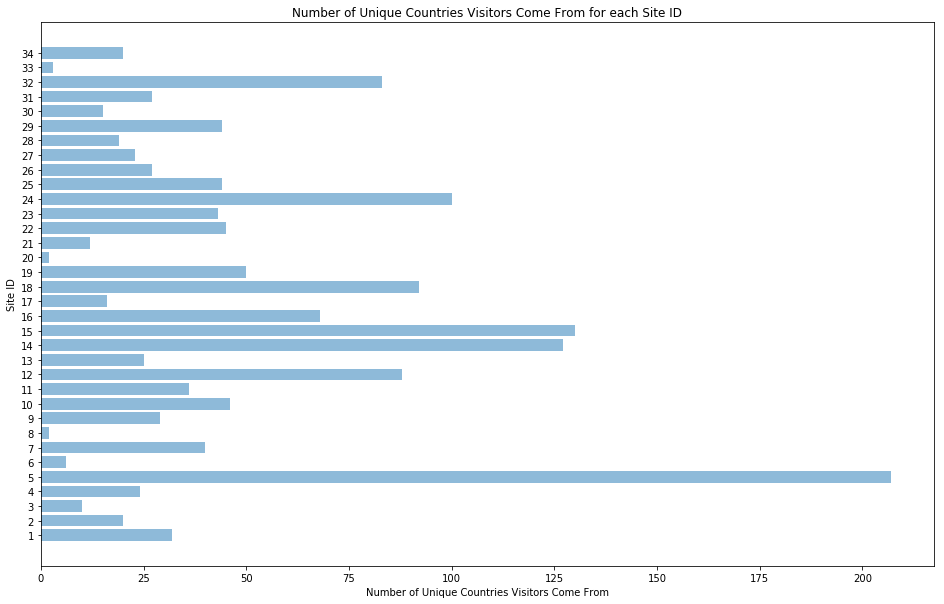

In [5]:
# Focus on site IDs 19, 17, and 13
siteIDvisitorCtry = searchData.groupby(['site_id'])['visitor_location_country_id'].agg(lambda x: len(np.unique(x)))

plt.figure(figsize = (16, 10))
plt.barh(np.arange(1, len(siteIDvisitorCtry)+1), siteIDvisitorCtry.as_matrix(), align = 'center', alpha = 0.5)
plt.yticks(np.arange(1, len(siteIDvisitorCtry)+1), np.arange(1, len(siteIDvisitorCtry)+1), rotation = 0)
plt.title("Number of Unique Countries Visitors Come From for each Site ID")
plt.ylabel("Site ID")
plt.xlabel("Number of Unique Countries Visitors Come From")
plt.show()
plt.close()

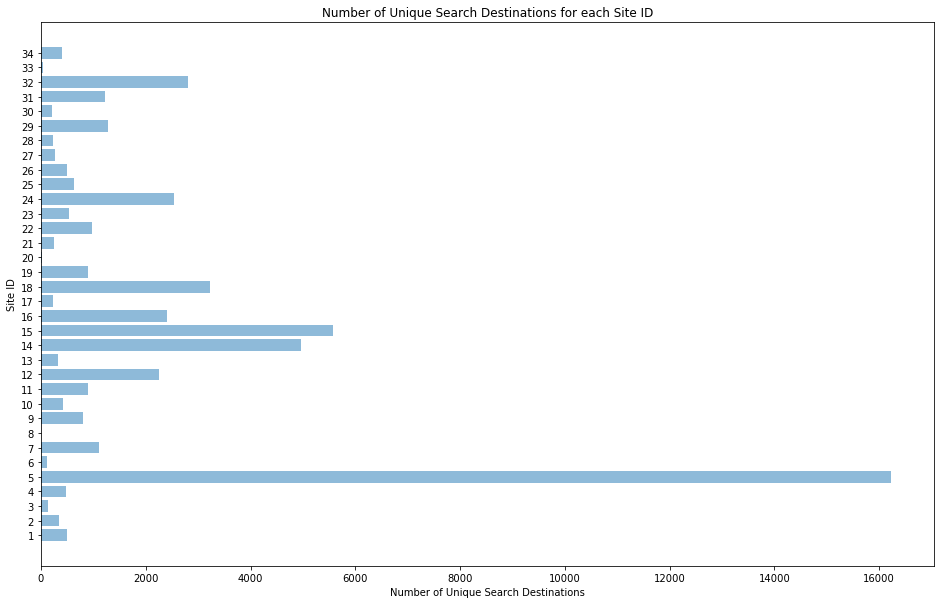

In [6]:
# Focus on site IDs 19, 17, and 13
siteIDsrchDest = searchData.groupby(['site_id'])['srch_destination_id'].agg(lambda x: len(np.unique(x)))

plt.figure(figsize = (16, 10))
plt.barh(np.arange(1, len(siteIDsrchDest)+1), siteIDsrchDest.as_matrix(), align = 'center', alpha = 0.5)
plt.yticks(np.arange(1, len(siteIDsrchDest)+1), np.arange(1, len(siteIDsrchDest)+1), rotation = 0)
plt.title("Number of Unique Search Destinations for each Site ID")
plt.ylabel("Site ID")
plt.xlabel("Number of Unique Search Destinations")
plt.show()
plt.close()

In [11]:
siteIDRegressionData = searchData

# Construct Site 13 dummy
siteIDRegressionData['site13'] = (siteIDRegressionData['site_id'] == 13)
siteIDRegressionData['site13'] = siteIDRegressionData['site13'].astype(int)

# Construct Site 17 dummy
siteIDRegressionData['site17'] = (siteIDRegressionData['site_id'] == 17)
siteIDRegressionData['site17'] = siteIDRegressionData['site17'].astype(int)

# Construct Site 19 dummy
siteIDRegressionData['site19'] = (siteIDRegressionData['site_id'] == 19)
siteIDRegressionData['site19'] = siteIDRegressionData['site19'].astype(int)

# Interacting site with promotion
siteIDRegressionData['site13:promo'] = siteIDRegressionData['site13'] * siteIDRegressionData['promotion_flag']
siteIDRegressionData['site17:promo'] = siteIDRegressionData['site17'] * siteIDRegressionData['promotion_flag']
siteIDRegressionData['site19:promo'] = siteIDRegressionData['site19'] * siteIDRegressionData['promotion_flag']

# Interacting site with brand_bool
siteIDRegressionData['site13:brand'] = siteIDRegressionData['site13'] * siteIDRegressionData['prop_brand_bool']
siteIDRegressionData['site17:brand'] = siteIDRegressionData['site17'] * siteIDRegressionData['prop_brand_bool']
siteIDRegressionData['site19:brand'] = siteIDRegressionData['site19'] * siteIDRegressionData['prop_brand_bool']


# Use log price instead
#siteIDRegressionData['log_price_usd'] = np.log(siteIDRegressionData['price_usd'])
# Some price is 0 and will result in -Inf, these records are converted to NaN and will be dropped later
#siteIDRegressionData.loc[np.isinf(siteIDRegressionData['log_price_usd']), 'log_price_usd'] = np.nan


In [12]:
# Logistic Regression to show interaction effects of site:promo and site:brand
target = ['booking_bool']
regressors = ['site13', 'site17', 'site19', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 
              'prop_log_historical_price', 'position', 'log_price_usd', 'promotion_flag', 'site13:promo', 'site17:promo', 
              'site19:promo', 'site13:brand', 'site17:brand', 'site19:brand']

siteIDlogitData = siteIDRegressionData[target + regressors].dropna()

logit = sm.Logit(siteIDlogitData[target], add_constant(siteIDlogitData[regressors]))
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.113212
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           booking_bool   No. Observations:              9902847
Model:                          Logit   Df Residuals:                  9902829
Method:                           MLE   Df Model:                           17
Date:                Thu, 15 Jun 2017   Pseudo R-squ.:                  0.1113
Time:                        15:39:32   Log-Likelihood:            -1.1211e+06
converged:                       True   LL-Null:                   -1.2615e+06
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
const                        -0.9828      0.017    -59.437      0.000        -

In [24]:
# Global Average number of days between search date and travel date (date to stay in hotel)
searchData['srch_booking_window'].mean()

37.62379070191872

In [25]:
# Average number of days between search date and travel date (date to stay in hotel), grouped by site ID
searchData.groupby(['site_id'])['srch_booking_window'].mean()

site_id
1     57.281595
2     53.504337
3     27.763222
4     56.411776
5     31.101286
6     29.781777
7     35.634568
8     22.000000
9     31.113332
10    44.987853
11    65.188241
12    49.261666
13    39.891780
14    37.706992
15    55.334850
16    40.495194
17    31.631979
18    63.093542
19    25.818533
20    26.733871
21    53.141882
22    42.109831
23    52.988934
24    47.195466
25    38.624495
26    33.511790
27    62.200848
28    56.474188
29    58.363305
30    38.826877
31    32.992881
32    72.193249
33    13.529889
34    34.660313
Name: srch_booking_window, dtype: float64

In [12]:
# Two Sample T-Test of Means (Overall vs Site 19)
scipy.stats.ttest_ind(searchData['srch_booking_window'].as_matrix(), 
                      searchData.loc[searchData['site_id'] == 19, 'srch_booking_window'].as_matrix(), equal_var = False)

Ttest_indResult(statistic=93.232516320887243, pvalue=0.0)

### Part 2a: Identifying Competitors using Descriptive Stats

In [3]:
# Hotel Chain Unique ID (brand_bool = 1)
HotelChainID = np.unique(searchData.loc[searchData['prop_brand_bool'] == 1, 'prop_id'])

print("Number of Unique Hotel Chains:", len(HotelChainID))

np.random.seed(123)
# Randomly sample 1000 IDs from the list
sampleHotel = np.random.choice(HotelChainID, size = 1000)

# For each of the sample hotel, extract the records of its competing hotels
sampleCompetitorsList = []
attrs = ['srch_id', 'prop_id', 'prop_country_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 
         'prop_location_score1', 'prop_historical_price', 'price_usd', 'price_usd_pernight', 'promotion_flag', 
         'orig_destination_distance']

for hotel in sampleHotel:
    srchIDs = list(searchData.loc[searchData['prop_id'] == hotel, 'srch_id'])
    competitors = searchData.loc[searchData['srch_id'].isin(srchIDs), attrs]
    sampleCompetitorsList.append(competitors)

Number of Unique Hotel Chains: 53115


#### Number of Unique Locations for Competitors

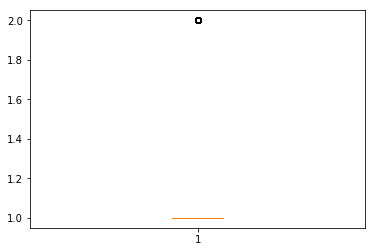

In [4]:
numUniqueCtry = []
for sampleCompetitors in sampleCompetitorsList:
    # Get the number of unique countries per search
    uniqueCtryPerSrch = sampleCompetitors.groupby(['srch_id']).agg({'prop_country_id': lambda x: len(np.unique(x))})
    numUniqueCtry += list(uniqueCtryPerSrch['prop_country_id'])

plt.boxplot(numUniqueCtry)
plt.show()
plt.close()

In [5]:
print("Percentage of Searches Involving Competitors Located in Different Country: %.2f%%" % \
      (np.sum(np.array(numUniqueCtry) != 1) / len(numUniqueCtry) * 100))

Percentage of Searches Involving Competitors Located in Different Country: 0.45%


In [6]:
print("Median: ", np.median(numUniqueCtry))
print("Mean: ", np.mean(numUniqueCtry))
print("Std Dev:", np.std(numUniqueCtry))

Median:  1.0
Mean:  1.00451771742
Std Dev: 0.0670619686895


#### Star Rating & Review Score

In [7]:
competeRatingCentred = []
competeReviewCentred = []

# For each hotel chain and its competitors
for hotel, sampleCompetitors in zip(sampleHotel, sampleCompetitorsList):
    
    # Extract the Hotel Chain's Star Rating and Review Score
    hotelScore = sampleCompetitors.loc[sampleCompetitors['prop_id'] == hotel, ['srch_id', 'prop_starrating', 
                                                                               'prop_review_score']]
    hotelScore = hotelScore.rename(columns = {'prop_starrating': 'target_prop_starrating', 
                                              'prop_review_score': 'target_prop_review_score'})
    
    # Subtract the hotel chain's star rating and review score from competitor's star rating / review score
    mergedDF = sampleCompetitors.merge(hotelScore, how = 'left', on = 'srch_id')
    mergedDF['centred_prop_starrating'] = mergedDF['prop_starrating'] - mergedDF['target_prop_starrating']
    mergedDF['centred_prop_review_score'] = mergedDF['prop_review_score'] - mergedDF['target_prop_review_score']
    competeRatingCentred += list(mergedDF['centred_prop_starrating'])
    competeReviewCentred += list(mergedDF['centred_prop_review_score'])


In [8]:
print("Median star rating difference between hotel chain and its competitors: %f" % np.median(competeRatingCentred))
print("Average star rating difference between hotel chain and its competitors: %.3f" % np.mean(competeRatingCentred))
print("Standard deviation - star rating difference between hotel chain and its competitors: %.3f" % np.std(competeRatingCentred))
print("Percentage of Competitors with Same Star Rating: %.2f%%" % \
      (np.sum(np.array(competeRatingCentred) == 0) / len(competeRatingCentred) * 100))
print("Percentage of Competitors with Star Rating Difference less than 1: %.2f%%" % \
      (np.sum(abs(np.array(competeRatingCentred)) <= 1) / len(competeRatingCentred) * 100))

Median star rating difference between hotel chain and its competitors: 0.000000
Average star rating difference between hotel chain and its competitors: -0.062
Standard deviation - star rating difference between hotel chain and its competitors: 1.031
Percentage of Competitors with Same Star Rating: 45.39%
Percentage of Competitors with Star Rating Difference less than 1: 88.75%


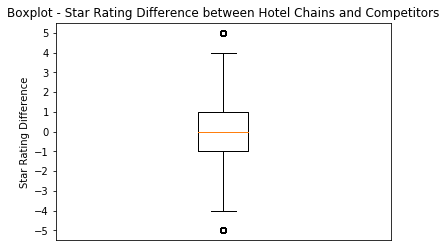

In [9]:
# Boxplot of Star Rating Difference
plt.boxplot(competeRatingCentred)
plt.yticks(np.arange(-5, 6, 1))
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Star Rating Difference")
plt.title("Boxplot - Star Rating Difference between Hotel Chains and Competitors")
plt.show()
plt.close()

In [10]:
# Some Hotels do not have review scores, these are removed from analysis
competeReviewCentred = np.array(competeReviewCentred)
competeReviewCentred = competeReviewCentred[~np.isnan(competeReviewCentred)]

# Print the statistics
print("Median review score difference between hotel chain and its competitors: %f" % np.median(competeReviewCentred))
print("Average review score difference between hotel chain and its competitors: %.3f" % np.mean(competeReviewCentred))
print("Standard deviation - review score difference between hotel chain and its competitors: %.3f" % np.std(competeReviewCentred))
print("Percentage of Competitors with Same Review Score: %.2f%%" % \
      (np.sum(np.array(competeReviewCentred) == 0) / len(competeReviewCentred) * 100))
print("Percentage of Competitors with Star Rating Difference less than 0.5: %.2f%%" % \
      (np.sum(abs(np.array(competeReviewCentred)) <= 0.5) / len(competeReviewCentred) * 100))
print("Percentage of Competitors with Star Rating Difference less than 1: %.2f%%" % \
      (np.sum(abs(np.array(competeReviewCentred)) <= 1) / len(competeReviewCentred) * 100))

Median review score difference between hotel chain and its competitors: 0.000000
Average review score difference between hotel chain and its competitors: -0.055
Standard deviation - review score difference between hotel chain and its competitors: 1.062
Percentage of Competitors with Same Review Score: 31.94%
Percentage of Competitors with Star Rating Difference less than 0.5: 70.10%
Percentage of Competitors with Star Rating Difference less than 1: 86.44%


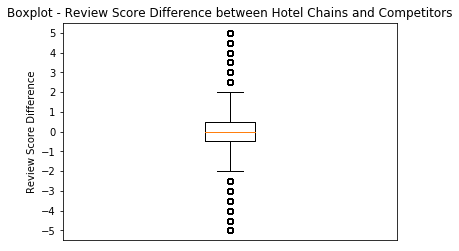

In [11]:
# Boxplot of Review Score Difference
plt.boxplot(competeReviewCentred)
plt.yticks(np.arange(-5, 6, 1))
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Review Score Difference")
plt.title("Boxplot - Review Score Difference between Hotel Chains and Competitors")
plt.show()
plt.close()

#### Hotel Brand Bool Proportion Test

In [12]:
allBrandBool = []

# For each hotel chain, get the brand_bool of its competitors
for sampleCompetitors in sampleCompetitorsList:
    competitorsBrand = list(sampleCompetitors['prop_brand_bool'].as_matrix())
    allBrandBool += competitorsBrand


In [13]:
# To get the overall proportion of hotel chains in ALL expedia search results
overallHotels = searchData.shape[0]
overallBrandHotels = searchData.loc[searchData['prop_brand_bool'] == 1, :].shape[0]

# To get the proportion of hotel chains in only the search results including the 1000 sample hotel chains
sampleHotels = len(allBrandBool)
sampleBrandHotels = np.sum(allBrandBool)

print("Number of Hotels shown in all Searches:", overallHotels)
print("Number of Hotel Chains shown in all Searches:", overallBrandHotels)
print("Percentage of Hotel Chains shown in all Searches: %.2f%%" % (overallBrandHotels / overallHotels * 100))
print("Number of Hotels shown in searches related to 1000 sample hotel chains:", sampleHotels)
print("Number of Hotel Chains shown in searches related to 1000 sample hotel chains:", sampleBrandHotels)
print("Percentage of Hotel Chains shown in searches related to 1000 sample hotel chains: %.2f%%" % \
      (sampleBrandHotels / sampleHotels * 100))

Number of Hotels shown in all Searches: 9917530
Number of Hotel Chains shown in all Searches: 6290731
Percentage of Hotel Chains shown in all Searches: 63.43%
Number of Hotels shown in searches related to 1000 sample hotel chains: 3537460
Number of Hotel Chains shown in searches related to 1000 sample hotel chains: 2715925
Percentage of Hotel Chains shown in searches related to 1000 sample hotel chains: 76.78%


In [14]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(np.array([overallBrandHotels, sampleBrandHotels]), np.array([overallHotels, sampleHotels]), 0)

(-458.08967375831821, 0.0)

### Location Score

In [15]:
competeLocationCentred = []

# For each hotel and its competitors
for hotel, sampleCompetitors in zip(sampleHotel, sampleCompetitorsList):
    
    # Extract the property location score1 of the hotel
    hotelLocScore = sampleCompetitors.loc[sampleCompetitors['prop_id'] == hotel, ['srch_id', 'prop_location_score1']]    
    hotelLocScore = hotelLocScore.rename(columns = {'prop_location_score1': 'target_prop_location_score1'})
    
    # Subtract the score from the hotel's competitors
    mergedDF = sampleCompetitors.merge(hotelLocScore, how = 'left', on = 'srch_id')
    mergedDF['centred_prop_location_score1'] = mergedDF['prop_location_score1'] - mergedDF['target_prop_location_score1']
    competeLocationCentred += list(mergedDF['centred_prop_location_score1'])

In [16]:
# Print the statistics
print("Median location score difference between hotel chain and its competitors: %f" % np.median(competeLocationCentred))
print("Average location score difference between hotel chain and its competitors: %.3f" % np.mean(competeLocationCentred))
print("Standard deviation - location score difference between hotel chain and its competitors: %.3f" % \
      np.std(competeLocationCentred))
print("Percentage of Competitors with Same Location Score: %.2f%%" % \
      (np.sum(np.array(competeLocationCentred) == 0) / len(competeLocationCentred) * 100))
print("Percentage of Competitors with Location Score Difference less than 0.5: %.2f%%" % \
      (np.sum(abs(np.array(competeLocationCentred)) <= 0.5) / len(competeLocationCentred) * 100))
print("Percentage of Competitors with Location Score Difference less than 1: %.2f%%" % \
      (np.sum(abs(np.array(competeLocationCentred)) <= 1) / len(competeLocationCentred) * 100))
print("Percentage of Competitors with Location Score Difference less than 1.5: %.2f%%" % \
      (np.sum(abs(np.array(competeLocationCentred)) <= 1.5) / len(competeLocationCentred) * 100))
print("Percentage of Competitors with Location Score Difference less than 2: %.2f%%" % \
      (np.sum(abs(np.array(competeLocationCentred)) <= 2) / len(competeLocationCentred) * 100))

Median location score difference between hotel chain and its competitors: 0.000000
Average location score difference between hotel chain and its competitors: 0.063
Standard deviation - location score difference between hotel chain and its competitors: 1.204
Percentage of Competitors with Same Location Score: 11.43%
Percentage of Competitors with Location Score Difference less than 0.5: 50.25%
Percentage of Competitors with Location Score Difference less than 1: 69.35%
Percentage of Competitors with Location Score Difference less than 1.5: 80.97%
Percentage of Competitors with Location Score Difference less than 2: 89.47%


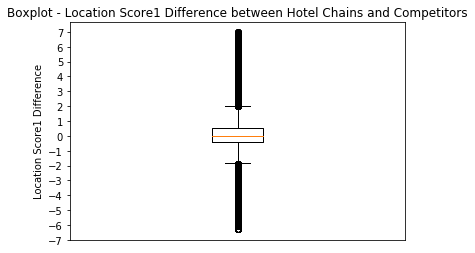

In [17]:
# Boxplot of Location Score1 Difference
plt.boxplot(competeLocationCentred)
plt.yticks(np.arange(-7, 8, 1))
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Location Score1 Difference")
plt.title("Boxplot - Location Score1 Difference between Hotel Chains and Competitors")
plt.show()
plt.close()


#### Historical Price Ratio

In [18]:
competeHistPriceCentred = []

# For each hotel and its competitors
for hotel, sampleCompetitors in zip(sampleHotel, sampleCompetitorsList):
    
    # Get the price of the hotel in last trading period
    hotelHistPrice = sampleCompetitors.loc[sampleCompetitors['prop_id'] == hotel, ['srch_id', 'prop_historical_price']]    
    hotelHistPrice = hotelHistPrice.rename(columns = {'prop_historical_price': 'target_prop_historical_price'})
    mergedDF = sampleCompetitors.merge(hotelHistPrice, how = 'left', on = 'srch_id')
    
    # Historical Price Ratio = Historical Price of Competitor / Historical Price of Hotel Chain
    mergedDF['centred_prop_historical_price'] \
    = mergedDF['prop_historical_price'] / mergedDF['target_prop_historical_price']
    
    competeHistPriceCentred += list(mergedDF['centred_prop_historical_price'])

In [19]:
# Print the statistics
print("Median Historical Price Ratio (Competitor's Historical Price / Hotel's Historical Price): %f" % \
      np.median(competeHistPriceCentred))
print("Average Historical Price Ratio (Competitor's Historical Price / Hotel's Historical Price): %.3f" % \
      np.mean(competeHistPriceCentred))
print("Standard deviation - Historical Price Ratio (Competitor's Historical Price / Hotel's Historical Price): %.3f" % \
      np.std(competeHistPriceCentred))
print("Percentage of Competitors with exactly same historical price: %.2f%%" % \
      (np.sum(np.array(competeHistPriceCentred) == 1) / len(competeHistPriceCentred) * 100))
print("Percentage of Competitors with less than 25%% Historical Price Difference: %.2f%%" % \
      (np.sum(abs(np.array(competeHistPriceCentred) - 1) <= 0.25) / len(competeHistPriceCentred) * 100))
print("Percentage of Competitors with less than 50%% Historical Price Difference: %.2f%%" % \
      (np.sum(abs(np.array(competeHistPriceCentred) - 1) <= 0.50) / len(competeHistPriceCentred) * 100))
print("Percentage of Competitors with less than 75%% Historical Price Difference: %.2f%%" % \
      (np.sum(abs(np.array(competeHistPriceCentred) - 1) <= 0.75) / len(competeHistPriceCentred) * 100))

Median Historical Price Ratio (Competitor's Historical Price / Hotel's Historical Price): 1.000000
Average Historical Price Ratio (Competitor's Historical Price / Hotel's Historical Price): 1.205
Standard deviation - Historical Price Ratio (Competitor's Historical Price / Hotel's Historical Price): 6.062
Percentage of Competitors with exactly same historical price: 18.41%
Percentage of Competitors with less than 25% Historical Price Difference: 53.29%
Percentage of Competitors with less than 50% Historical Price Difference: 79.19%
Percentage of Competitors with less than 75% Historical Price Difference: 90.39%


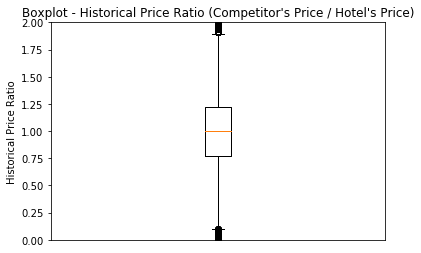

In [20]:
# Boxplot of Historical Price Ratio (Competitor's Historical Price / Hotel's Historical Price)
plt.boxplot(competeHistPriceCentred)
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.axis([0, 2, 0, 2])
plt.ylabel("Historical Price Ratio")
plt.title("Boxplot - Historical Price Ratio (Competitor's Price / Hotel's Price)")
plt.show()
plt.close()


#### Price Ratio

In [4]:
competePriceUSDRatio = []

# Fo each hotel and its competitors
for hotel, sampleCompetitors in zip(sampleHotel, sampleCompetitorsList):
    
    # Extract the price of the hotel
    hotelPriceUSD = sampleCompetitors.loc[sampleCompetitors['prop_id'] == hotel, ['srch_id', 'price_usd']]
    hotelPriceUSD = hotelPriceUSD.rename(columns = {'price_usd': 'target_price_usd'})
    
    # Divide the competitor's pricing with the hotel's pricing = price ratio
    mergedDF = sampleCompetitors.merge(hotelPriceUSD, how = 'left', on = 'srch_id')
    mergedDF['price_usd_ratio'] = mergedDF['price_usd'] / mergedDF['target_price_usd']
    
    competePriceUSDRatio += list(mergedDF['price_usd_ratio'])

In [5]:
# Print the statistics
print("Median Price Ratio (Competitor's Price / Hotel's Price): %f" % np.median(competePriceUSDRatio))
print("Average Price Ratio (Competitor's Price / Hotel's Price): %.3f" % np.mean(competePriceUSDRatio))
print("Standard deviation - Price Ratio (Competitor's Price / Hotel's Price): %.3f" % \
      np.std(competePriceUSDRatio))
print("Percentage of Competitors with exactly same price: %.2f%%" % \
      (np.sum(np.array(competePriceUSDRatio) == 1) / len(competePriceUSDRatio) * 100))
print("Percentage of Competitors with less than 25%% Price Difference: %.2f%%" % \
      (np.sum(abs(np.array(competePriceUSDRatio) - 1) <= 0.25) / len(competePriceUSDRatio) * 100))
print("Percentage of Competitors with less than 50%% Price Difference: %.2f%%" % \
      (np.sum(abs(np.array(competePriceUSDRatio) - 1) <= 0.50) / len(competePriceUSDRatio) * 100))
print("Percentage of Competitors with less than 75%% Price Difference: %.2f%%" % \
      (np.sum(abs(np.array(competePriceUSDRatio) - 1) <= 0.75) / len(competePriceUSDRatio) * 100))


Median Price Ratio (Competitor's Price / Hotel's Price): 1.000000
Average Price Ratio (Competitor's Price / Hotel's Price): 1.143
Standard deviation - Price Ratio (Competitor's Price / Hotel's Price): 1.369
Percentage of Competitors with exactly same price: 5.21%
Percentage of Competitors with less than 25% Price Difference: 44.14%
Percentage of Competitors with less than 50% Price Difference: 72.20%
Percentage of Competitors with less than 75% Price Difference: 86.54%


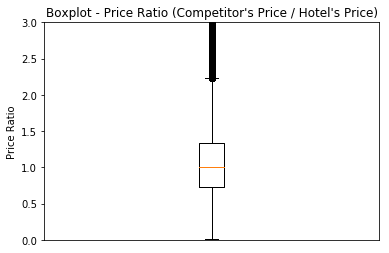

In [7]:
# Boxplot of Price Ratio (Competitor's Price / Hotel's Price)
plt.boxplot(competePriceUSDRatio)
#plt.yticks(np.arange(-7, 8, 1))
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.axis([0, 2, 0, 3])
plt.ylabel("Price Ratio")
plt.title("Boxplot - Price Ratio (Competitor's Price / Hotel's Price)")
plt.show()
plt.close()


### Promotion Flag

In [86]:
# Split into two scenarios, hotel chain has promotion and hotel chain doesn't have promotion
promoCompetePrmtFlag = []
nonPromoCompetePrmtFlag = []

# For each hotel and its competitors
for hotel, sampleCompetitors in zip(sampleHotel, sampleCompetitorsList):
    
    # Get the search IDs that involve sample hotels having promotions
    promoSrchID = sampleCompetitors.loc[(sampleCompetitors['prop_id'] == hotel) & (sampleCompetitors['promotion_flag'] == 1), 
                                        'srch_id'].as_matrix()
    
    # Scenario 1: Competitors which show up in the same search results when hotel chain is having promotion
    promoCompete = sampleCompetitors.loc[sampleCompetitors['srch_id'].isin(promoSrchID), :]
    # Scenario 2: Competitors which show up in the same search results when hotel chain is not having promotion
    nonPromoCompete = sampleCompetitors.loc[~sampleCompetitors['srch_id'].isin(promoSrchID), :]
    
    # Promotion Flags of the competitors in these 2 scenarios
    promoCompetePrmtFlag += list(promoCompete['promotion_flag'].as_matrix())
    nonPromoCompetePrmtFlag += list(nonPromoCompete['promotion_flag'].as_matrix())   

In [91]:
# To get the overall proportion of promotions in ALL expedia search results
overallHotels = searchData.shape[0]
overallPromoHotels = searchData.loc[searchData['promotion_flag'] == 1, :].shape[0]

# Scenario 1: To get the proportion of competitors having promotions when we are having promotions
PromoSampleNumHotels = len(promoCompetePrmtFlag)
PromoSampleNumPromotions = np.sum(promoCompetePrmtFlag)

# Scenario 2: To get the proportion of competitors having promotions when we are not having promotions
NonPromoSampleNumHotels = len(nonPromoCompetePrmtFlag)
NonPromoSampleNumPromotions = np.sum(nonPromoCompetePrmtFlag)

# Overall percentages of promotions
print("Number of Hotels shown in all Searches:", overallHotels)
print("Number of Promotions shown in all Searches:", overallPromoHotels)
print("Proportion of Promotions shown in all Searches: %.2f%%" % ((overallPromoHotels / overallHotels) * 100))

# Percentages of promotions in scenario 1
print("Number of Hotels shown in searches in Scenario 1:", PromoSampleNumHotels)
print("Number of Promotions in Scenario 1:", PromoSampleNumPromotions)
print("Percentages of Promotions in Scenario 1: %.2f%%" % ((PromoSampleNumPromotions / PromoSampleNumHotels) * 100))

# Percentages of promotions in scenario 2
print("Number of Hotels shown in searches in Scenario 2:", NonPromoSampleNumHotels)
print("Number of Promotions in Scenario 2:", NonPromoSampleNumPromotions)
print("Percentages of Promotions in Scenario 2: %.2f%%" % ((NonPromoSampleNumPromotions / NonPromoSampleNumHotels) * 100))


Number of Hotels shown in all Searches: 9917530
Number of Promotions shown in all Searches: 2139822
Proportion of Promotions shown in all Searches: 21.58%
Number of Hotels shown in searches in Scenario 1: 555278
Number of Promotions in Scenario 1: 210718
Percentages of Promotions in Scenario 1: 37.95%
Number of Hotels shown in searches in Scenario 2: 2982182
Number of Promotions in Scenario 2: 515941
Percentages of Promotions in Scenario 2: 17.30%


In [89]:
proportions_ztest(np.array([overallPromoHotels, PromoSampleNumPromotions]), np.array([overallHotels, PromoSampleNumHotels]), 0)

(-284.55674946158825, 0.0)

In [90]:
proportions_ztest(np.array([overallPromoHotels, NonPromoSampleNumPromotions]), 
                  np.array([overallHotels, NonPromoSampleNumHotels]), 0)

(160.10474172582738, 0.0)

### Original Destination Distance between Visitor and Hotel

In [92]:
competeDistanceCentred = []

# For each hotel and its competitors
for hotel, sampleCompetitors in zip(sampleHotel, sampleCompetitorsList):
    
    # Extract the hotel's distance to the user
    hotelDist = sampleCompetitors.loc[sampleCompetitors['prop_id'] == hotel, ['srch_id', 'orig_destination_distance']]    
    hotelDist = hotelDist.rename(columns = {'orig_destination_distance': 'target_orig_destination_distance'})
    
    mergedDF = sampleCompetitors.merge(hotelDist, how = 'left', on = 'srch_id')
    
    # Subtract hotel's distance from competitor's distance: as a proxy to the distances between hotels
    mergedDF['centred_orig_destination_distance'] \
    = mergedDF['orig_destination_distance'] - mergedDF['target_orig_destination_distance']
    
    competeDistanceCentred += list(mergedDF['centred_orig_destination_distance'])

In [93]:
# Many searches do not have distance between hotel and visitor, these entries are discarded
competeDistanceCentred = np.array(competeDistanceCentred)
competeDistanceCentred = competeDistanceCentred[~np.isnan(competeDistanceCentred)]

In [102]:
# Print the statistics
print("Median Distance Difference between a Hotel Chain and Competitor: %f" % np.median(competeDistanceCentred))
print("Average Distance Difference between a Hotel Chain and Competitor: %.3f" % np.mean(competeDistanceCentred))
print("Standard deviation - Distance Difference between a Hotel Chain and Competitor: %.3f" % \
      np.std(competeDistanceCentred))
print("Percentage of Competitors Less Than 0.5km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 0.5) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 1km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 1) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 1.5km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 1.5) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 2km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 2) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 2.5km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 2.5) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 3km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 3) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 3.5km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 3.5) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 4km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 4) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 4.5km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 4.5) / len(competeDistanceCentred) * 100))
print("Percentage of Competitors Less Than 5km away from our Hotel: %.2f%%" % \
      (np.sum(abs(np.array(competeDistanceCentred)) <= 5) / len(competeDistanceCentred) * 100))


Median Distance Difference between a Hotel Chain and Competitor: 0.000000
Average Distance Difference between a Hotel Chain and Competitor: 0.055
Standard deviation - Distance Difference between a Hotel Chain and Competitor: 5.873
Percentage of Competitors Less Than 0.5km away from our Hotel: 30.34%
Percentage of Competitors Less Than 1km away from our Hotel: 42.57%
Percentage of Competitors Less Than 1.5km away from our Hotel: 50.69%
Percentage of Competitors Less Than 2km away from our Hotel: 57.17%
Percentage of Competitors Less Than 2.5km away from our Hotel: 62.51%
Percentage of Competitors Less Than 3km away from our Hotel: 67.01%
Percentage of Competitors Less Than 3.5km away from our Hotel: 70.85%
Percentage of Competitors Less Than 4km away from our Hotel: 74.13%
Percentage of Competitors Less Than 4.5km away from our Hotel: 76.88%
Percentage of Competitors Less Than 5km away from our Hotel: 79.27%


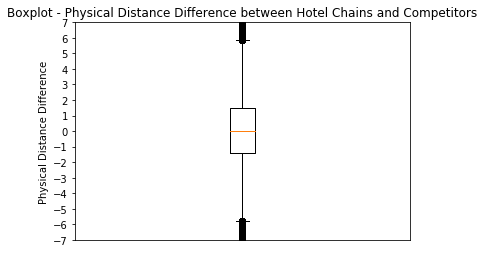

In [101]:
# Boxplot of Physical Distance Difference Between Hotel and its Competitors
plt.boxplot(competeDistanceCentred)
plt.yticks(np.arange(-7, 8, 1))
plt.axis([0, 2, -7, 7])
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Physical Distance Difference")
plt.title("Boxplot - Physical Distance Difference between Hotel Chains and Competitors")
plt.show()
plt.close()


### Top Hotels with High CTR and Conversion / Impression (Hotels must show up at least 100 times)

In [174]:
# Calculate CTR and Conversion/Impression Rate
bookRate = searchData.groupby(['prop_id'])['booking_bool'].agg(['mean', 'count'])
clickRate = searchData.groupby(['prop_id'])['click_bool'].agg(['mean', 'count'])
# Select only those that show up at least 100 times in search results
bookRate = bookRate.loc[bookRate['count'] >= 100, :]
clickRate = clickRate.loc[clickRate['count'] >= 100, :]
# Rename columns
bookRate = bookRate.rename(columns = {'mean': 'Conversion/Impression'})
clickRate = clickRate.rename(columns = {'mean': 'CTR'})
# Join the two metrics
metricsDF = bookRate.merge(clickRate, how = 'left', left_index = True, right_index = True)
metriccsDF = metricsDF[['Conversion/Impression', 'CTR']]

In [177]:
metriccsDF.sort_values(['Conversion/Impression', 'CTR'], ascending = [False, False])

,Conversion/Impression,CTR
prop_id,,
88359,0.475248,0.514851
66456,0.348416,0.380090
86247,0.343750,0.390625
60275,0.343284,0.373134
29792,0.330579,0.371901
17669,0.315436,0.422819
8617,0.309211,0.401316
50355,0.290816,0.331633
10429,0.284314,0.352941


### Clustering Approach

In [6]:
ctryID = 15
clusterAttrs = ['prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_historical_price', 
                'price_usd_pernight', 'promotion_flag']

clusteringData = searchData.loc[searchData['prop_country_id'] == ctryID, clusterAttrs].dropna()
clusteringDataScaled = preprocessing.scale(clusteringData.copy())

print("Number of Records in this country:", clusteringDataScaled.shape[0])

Number of Records in this country: 47778


In [7]:
clustering = AgglomerativeClustering(linkage= 'average', n_clusters = 50)
clustering.fit(clusteringDataScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=50,
            pooling_func=<function mean at 0x00000285637C18C8>)

In [60]:
clusterIdx = np.where(clustering.labels_ == 0)
clusteringData.iloc[clusterIdx]

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_historical_price,price_usd_pernight,promotion_flag
334,4,4.5,1,2.89,170.715768,114.120000,1
1000,5,3.5,0,3.26,174.164456,250.000000,1
1007,4,4.5,1,2.71,144.026887,98.000000,1
1009,4,4.5,1,2.89,151.411304,123.000000,1
1019,5,4.0,1,4.64,304.904923,316.000000,1
8892,4,4.0,1,3.78,120.301369,74.000000,1
8902,4,3.5,0,3.22,202.350228,67.000000,1
9186,4,3.5,0,3.78,186.792804,32.673333,1
19886,4,4.5,1,3.04,317.348329,174.666667,1
19892,4,4.5,1,4.62,219.203386,117.000000,1


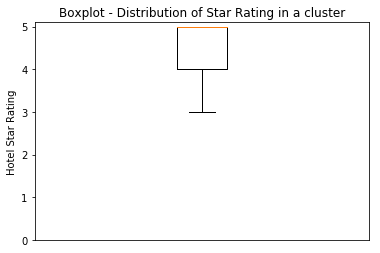

In [61]:
# Boxplot of Hotel Star Rating
plt.boxplot(clusteringData.iloc[clusterIdx]['prop_starrating'].as_matrix())
plt.yticks(np.arange(0, 6, 1))
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Hotel Star Rating")
plt.title("Boxplot - Distribution of Star Rating in a cluster")
plt.show()
plt.close()

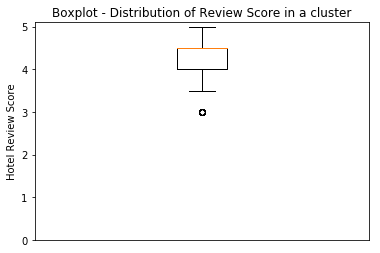

In [62]:
# Boxplot of Hotel Review Score
plt.boxplot(clusteringData.iloc[clusterIdx]['prop_review_score'].as_matrix())
plt.yticks(np.arange(0, 6, 1))
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Hotel Review Score")
plt.title("Boxplot - Distribution of Review Score in a cluster")
plt.show()
plt.close()

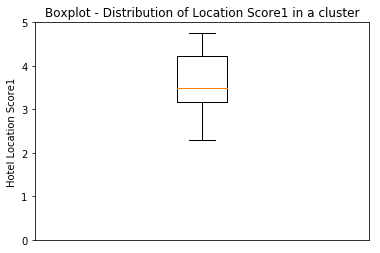

In [63]:
# Boxplot of Hotel Location Score1
plt.boxplot(clusteringData.iloc[clusterIdx]['prop_location_score1'].as_matrix())
plt.yticks(np.arange(0, 6, 1))
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Hotel Location Score1")
plt.title("Boxplot - Distribution of Location Score1 in a cluster")
plt.show()
plt.close()


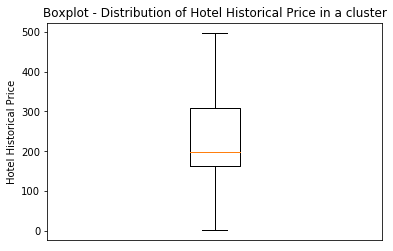

In [64]:
# Boxplot of Hotel Historical Price
plt.boxplot(clusteringData.iloc[clusterIdx]['prop_historical_price'].as_matrix())
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
plt.ylabel("Hotel Historical Price")
plt.title("Boxplot - Distribution of Hotel Historical Price in a cluster")
plt.show()
plt.close()

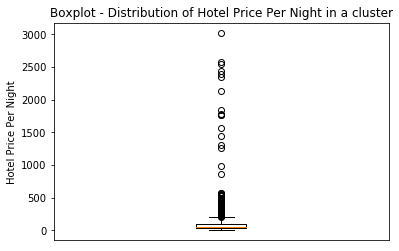

In [65]:
# Boxplot of Hotel Historical Price
plt.boxplot(clusteringData.iloc[clusterIdx]['price_usd_pernight'].as_matrix())
plt.tick_params(axis = 'x', bottom = 'off', labelbottom = 'off')
#plt.yticks(np.arange(0, 1201, 100))
plt.ylabel("Hotel Price Per Night")
plt.title("Boxplot - Distribution of Hotel Price Per Night in a cluster")
plt.show()
plt.close()

### Part 2b: Effects of Relative Price on Probability of Sale

In [3]:
regressionData = searchData

# Construct (Price / Ave Price) Ratio
regressionDataMeanPrice = regressionData.groupby(['srch_id'])['price_usd'].mean()
regressionDataMeanPrice.name = 'price_usd_average'

# Construct (StarRating - Ave StarRating)
regressionDataStarRating = regressionData.groupby(['srch_id'])['prop_starrating'].mean()
regressionDataStarRating.name = 'prop_starrating_average'

# Construct (ReviewScore - Ave ReviewScore)
regressionDataReviewScore = regressionData.groupby(['srch_id'])['prop_review_score'].mean()
regressionDataReviewScore.name = 'prop_review_score_average'

# Construct (LocationScore1 - Ave LocationScore1)
regressionDataLocScore1 = regressionData.groupby(['srch_id'])['prop_location_score1'].mean()
regressionDataLocScore1.name = 'prop_location_score1_average'

# Construct (Historical Price / Ave Historical Price)
regressionDataHistPrice = regressionData.groupby(['srch_id'])['prop_historical_price'].mean()
regressionDataHistPrice.name = 'prop_historical_price_average'


In [4]:
# New Regressor: (Price / Ave Price) Ratio
regressionData = regressionData.merge(pd.DataFrame({regressionDataMeanPrice.index.name: regressionDataMeanPrice.index, 
                                                    regressionDataMeanPrice.name: regressionDataMeanPrice.values}), 
                                      how = 'left', on = 'srch_id')
regressionData['price_ratio'] = regressionData['price_usd'] / regressionData['price_usd_average']
regressionData['price_ratio_sq'] = regressionData['price_ratio']**2

# New Regressor: (StarRating - Ave StarRating)
regressionData = regressionData.merge(pd.DataFrame({regressionDataStarRating.index.name: regressionDataStarRating.index, 
                                                    regressionDataStarRating.name: regressionDataStarRating.values}), 
                                      how = 'left', on = 'srch_id')
regressionData['prop_starrating_centred'] = regressionData['prop_starrating'] - regressionData['prop_starrating_average']

# New Regressor: (ReviewScore - Ave ReviewScore)
regressionData = regressionData.merge(pd.DataFrame({regressionDataReviewScore.index.name: regressionDataReviewScore.index, 
                                                    regressionDataReviewScore.name: regressionDataReviewScore.values}), 
                                      how = 'left', on = 'srch_id')
regressionData['prop_review_score_centred'] = regressionData['prop_review_score'] - regressionData['prop_review_score_average']

# New Regressor: (LocationScore1 - LocationScore1)
regressionData = regressionData.merge(pd.DataFrame({regressionDataLocScore1.index.name: regressionDataLocScore1.index, 
                                                    regressionDataLocScore1.name: regressionDataLocScore1.values}), 
                                      how = 'left', on = 'srch_id')
regressionData['prop_location_score1_centred'] \
= regressionData['prop_location_score1'] - regressionData['prop_location_score1_average']

# New Regressor: (Historical Price / Ave Historical Price) Ratio
regressionData = regressionData.merge(pd.DataFrame({regressionDataHistPrice.index.name: regressionDataHistPrice.index, 
                                                    regressionDataHistPrice.name: regressionDataHistPrice.values}), 
                                      how = 'left', on = 'srch_id')
regressionData['historical_price_ratio'] \
= regressionData['prop_historical_price'] / regressionData['prop_historical_price_average']
regressionData['historical_price_ratio_sq'] = regressionData['historical_price_ratio']**2

# New Regressor: (Brand Bool * Price Ratio) interaction term
regressionData['brand:priceratio'] = regressionData['prop_brand_bool'] * regressionData['price_ratio']


In [5]:
target = ['booking_bool']
regressors = ['price_ratio', 'brand:priceratio', 'price_ratio_sq', 'prop_starrating_centred',  'prop_review_score_centred', 
              'prop_brand_bool', 'prop_location_score1_centred', 'historical_price_ratio', 'historical_price_ratio_sq', 
              'position', 'promotion_flag']

logitData = regressionData[target + regressors].dropna()

logit = sm.Logit(logitData[target], add_constant(logitData[regressors]))
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.112098
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:           booking_bool   No. Observations:              9902900
Model:                          Logit   Df Residuals:                  9902888
Method:                           MLE   Df Model:                           11
Date:                Thu, 15 Jun 2017   Pseudo R-squ.:                  0.1200
Time:                        11:34:23   Log-Likelihood:            -1.1101e+06
converged:                       True   LL-Null:                   -1.2615e+06
                                        LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                           -1.8033      0.018   -100.707      0.00

In [181]:
# Accuracy Score
temp = result.predict(add_constant(logitData[regressors]))
truth = logitData[target].as_matrix().flatten()
print("In-Sample Accuracy: %.4f" % (np.sum(abs(truth - temp) < 0.5) / logitData.shape[0]))

In-Sample Accuracy: 0.9721


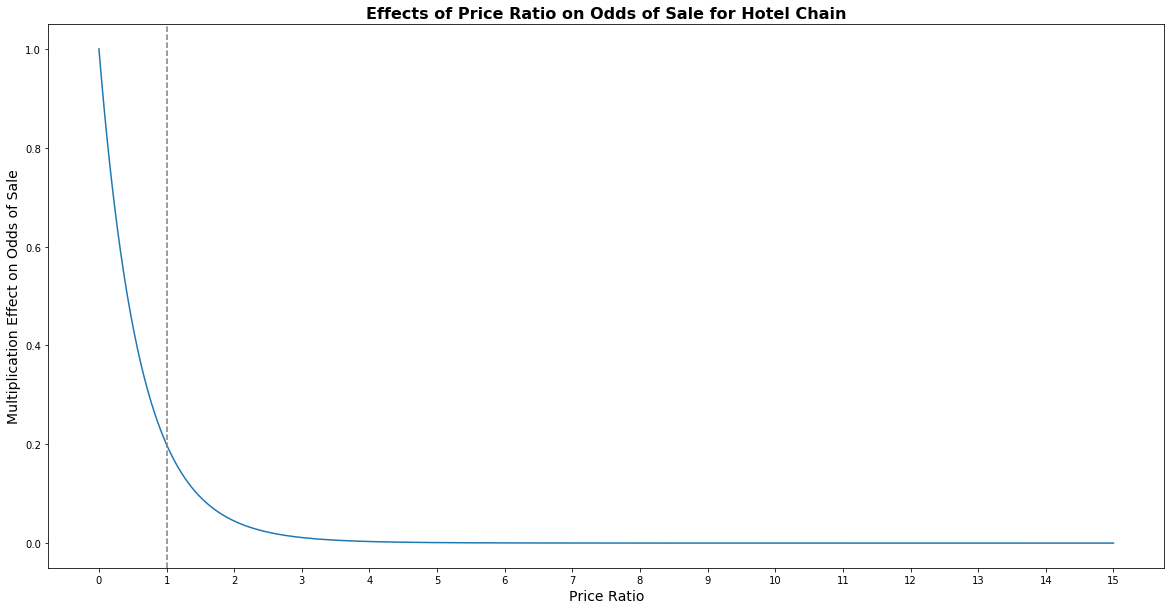

In [67]:
def graph(formula, x_range, vline, plt_title, plt_ytitle, plt_xtitle):  
    x = np.array(x_range)  
    y = eval(formula)
    fig = plt.figure(figsize = (20, 10))
    #fig.suptitle(plt_title, fontsize=14, fontweight='bold')
    plt.plot(x, y) 
    plt.title(plt_title, fontweight = 'bold', fontsize = 16)
    plt.xticks(np.arange(0, 15.01, 1))
    plt.axvline(vline, color = 'grey', ls = 'dashed')
    plt.ylabel(plt_ytitle, fontsize = 14)
    plt.xlabel(plt_xtitle, fontsize = 14)
    plt.show()

# Price Ratio
size_formula = 'np.exp(-1.4758*x -0.1940*x + 0.0577*(x**2))'
size_range = np.arange(0, 15.01, 0.01)
graph(size_formula, size_range, 1.0, "Effects of Price Ratio on Odds of Sale for Hotel Chain", 
      "Multiplication Effect on Odds of Sale", "Price Ratio")

#### Optimize Expected Revenue

In [78]:
# Define Objective Function
def f(x): 
    odds = np.exp(-1.0593 - 1.6698 * x + 0.0577 * (x**2))
    return (odds / (1 + odds)) * x

# Maximise f(x) = minimise -f(x)
max_x = scipy.optimize.fmin(lambda x: -f(x), 0)

Optimization terminated successfully.
         Current function value: -0.069833
         Iterations: 24
         Function evaluations: 48


In [79]:
print("Optimal Price Ratio:", max_x[0])

Optimal Price Ratio: 0.699125


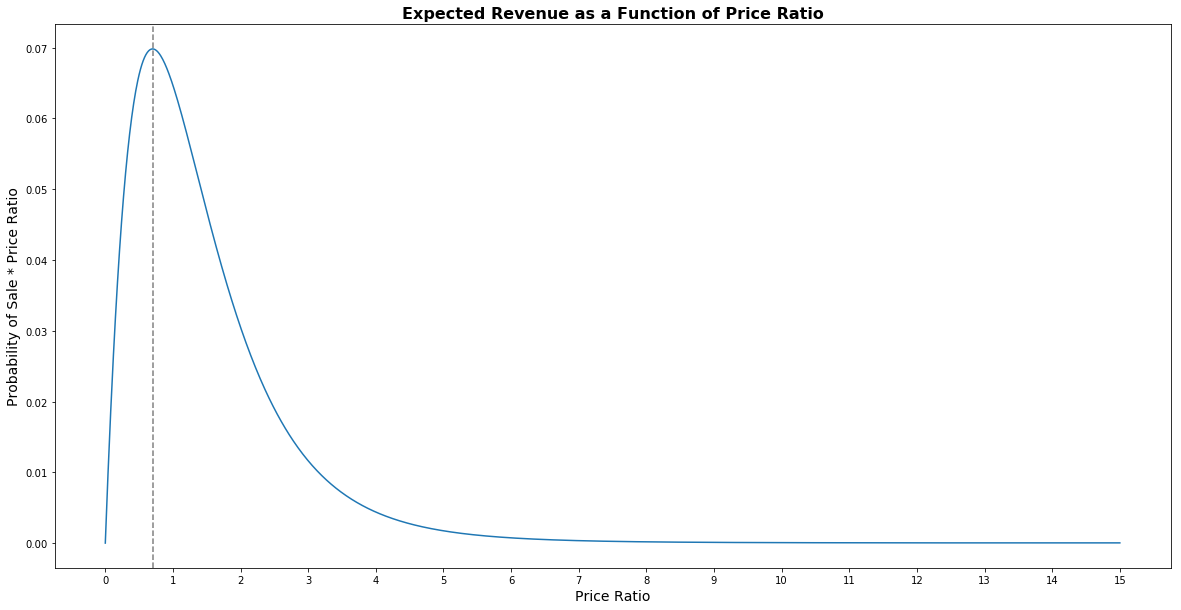

In [71]:
# Plot the objective function w.r.t. price ratio
size_formula = 'np.exp(-1.0593 - 1.6698 * x + 0.0577 * (x**2)) * x / (1 + np.exp(-1.0593 - 1.6698 * x + 0.0577 * (x**2)))'
size_range = np.arange(0, 15.01, 0.01)
graph(size_formula, size_range, max_x[0], "Expected Revenue as a Function of Price Ratio", 
      "Probability of Sale * Price Ratio", "Price Ratio")


## Appendix

In [36]:
searchData.loc[searchData['srch_id'] == 565631, 'orig_destination_distance']

8424846    1000.35
8424847    1000.47
8424848    1000.57
8424849     999.98
8424850     999.81
Name: orig_destination_distance, dtype: float64

In [39]:
np.max(searchData['orig_destination_distance'])

11692.98

In [34]:
distStdBySrch = searchData.groupby(['srch_id'])['orig_destination_distance'].std()
np.nanmean(distStdBySrch)

3.3470835197727058

In [38]:
distStdBySrch[distStdBySrch > 100]

srch_id
506967    110.937681
Name: orig_destination_distance, dtype: float64